# Reflection


In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions.
This is then used downstream for things like re-planning, search, or evaluation.

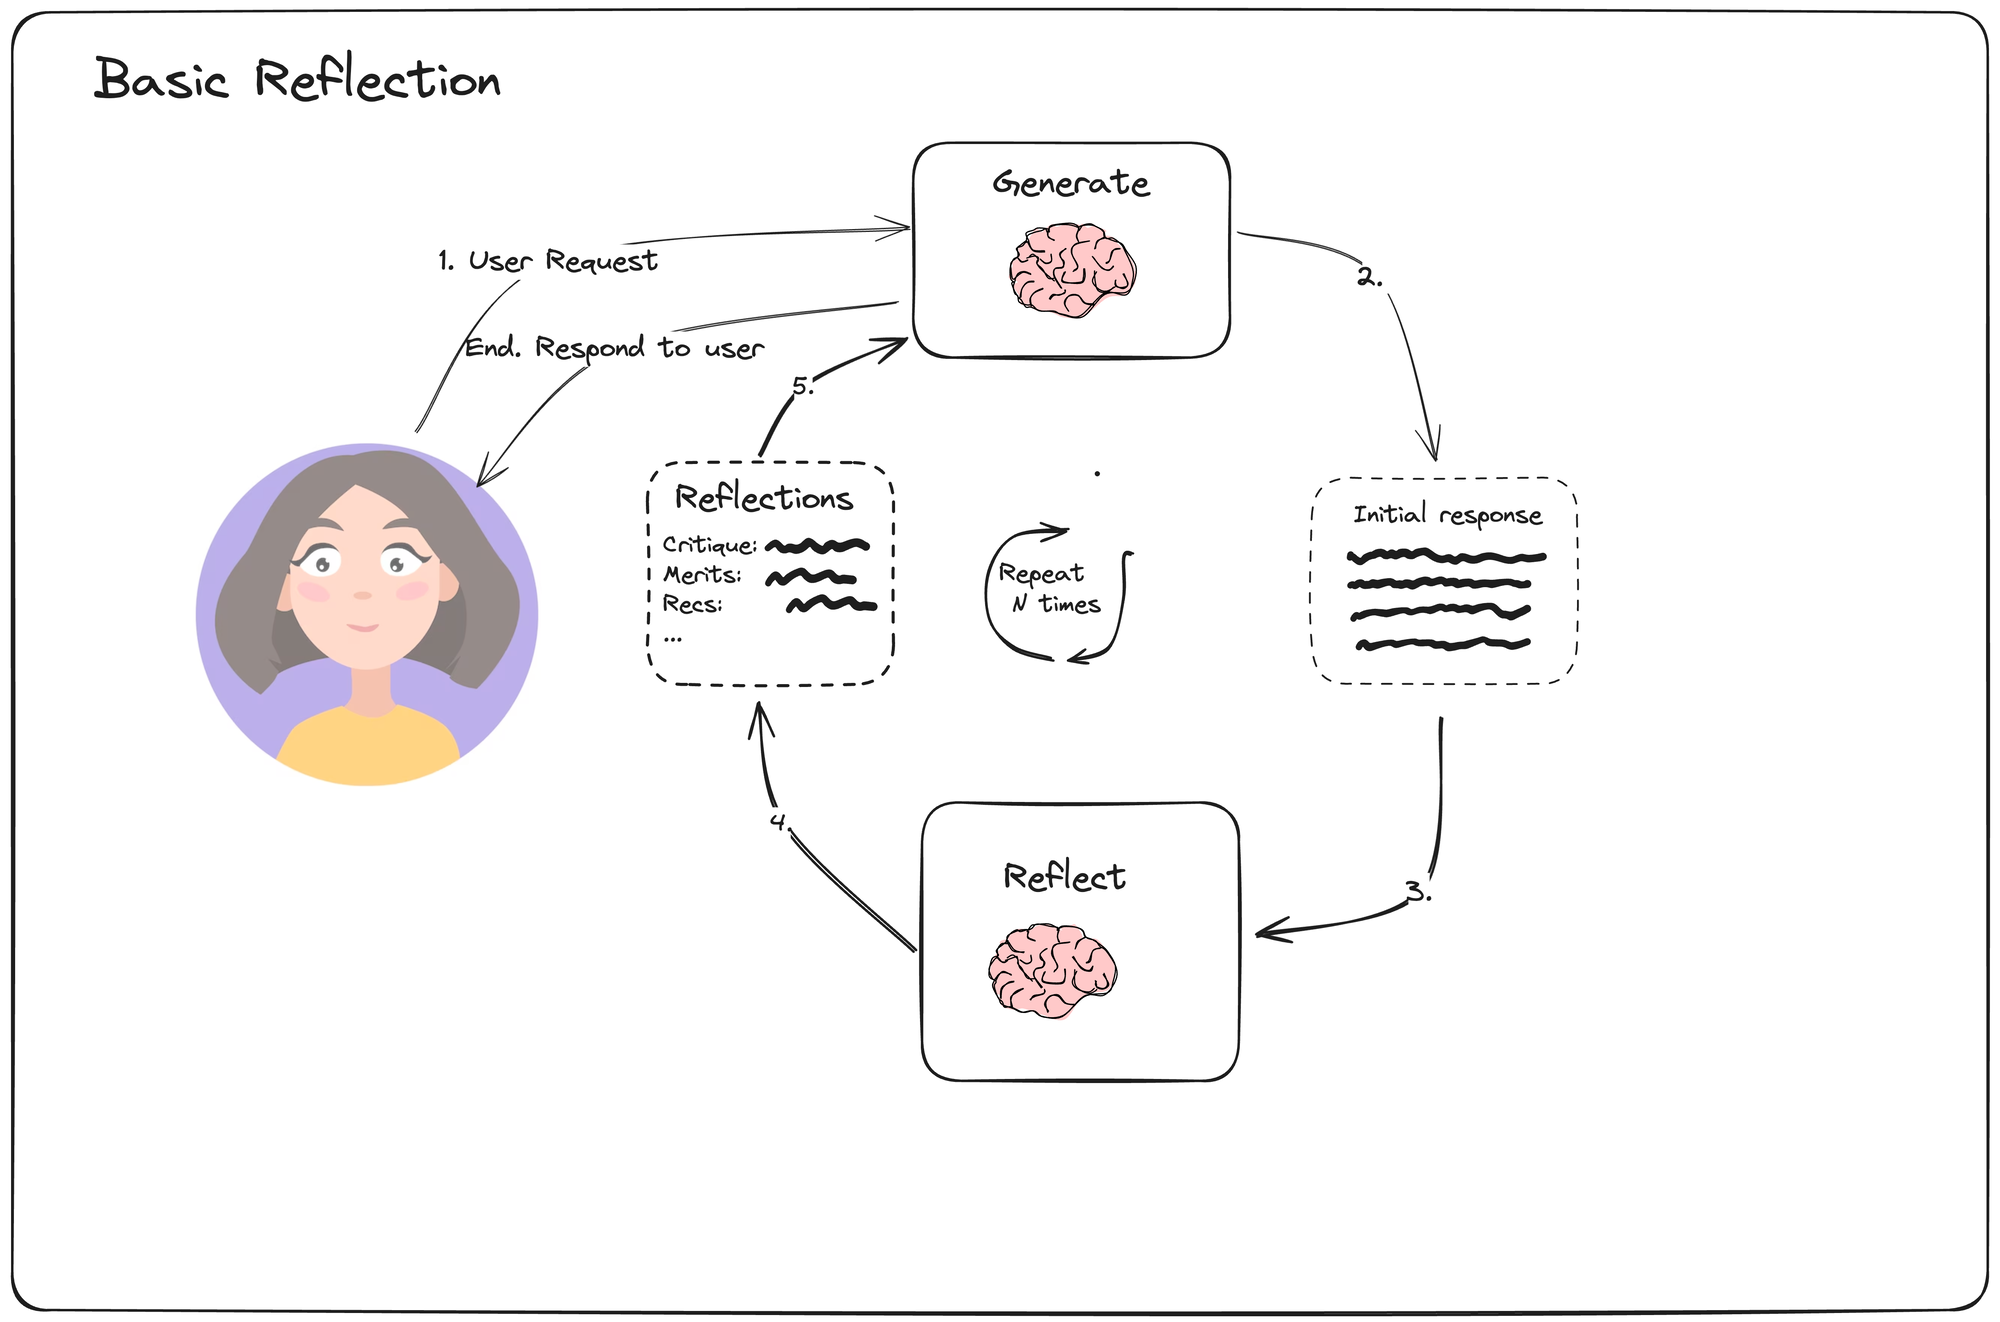

This notebook demonstrates a very simple form of reflection in LangGraph.

## Setup

First, let's install our required packages and set our API keys

In [1]:
%pip install -U --quiet  langgraph langchain-fireworks
%pip install -U --quiet tavily-python

In [ ]:
import getpass
import os


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("FIREWORKS_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [3]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_fireworks import ChatFireworks

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatFireworks(
    model="accounts/fireworks/models/mixtral-8x7b-instruct", max_tokens=32768
)
generate = prompt | llm

In [4]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

Title: The Eternal Relevance of The Little Prince in Modern Childhood

Introduction:
Antoine de Saint-Exupéry's The Little Prince is a timeless novella that has captured the hearts and minds of children and adults alike for over seven decades. Its enduring charm and profound wisdom have transcended generations, making it a classic staple in childhood literature. This essay explores the reasons why The Little Prince remains relevant in modern childhood.

First Paragraph:
One of the primary reasons for The Little Prince's relevance is its exploration of themes that resonate with children today. The story addresses universal aspects of childhood, such as the struggle to understand the world, the desire for friendship and love, and the pain of loss and loneliness. The Little Prince's encounters with various grown-ups, each representing different facets of adult absurdity, mirror the confusion and disillusionment children experience as they grow and navigate their way through a complex worl

### Reflect

In [5]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [6]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Essay Critique and Recommendations:

Title: The Eternal Relevance of The Little Prince in Modern Childhood

Introduction:
The introduction provides a clear and concise overview of the topic, setting the stage for the rest of the essay. The author has done an excellent job of establishing the significance of The Little Prince and its enduring appeal.

First Paragraph:
The first paragraph effectively highlights the universal themes present in The Little Prince that resonate with children today. The author could improve the paragraph by providing specific examples from the book to illustrate each theme, making the essay more engaging and demonstrating a deeper understanding of the text.

Second Paragraph:
The second paragraph emphasizes the values promoted by The Little Prince and their relevance to modern childhood. The author could expand on this by discussing how these values can be applied in everyday life, providing practical examples for children to follow. Additionally, the author 

### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [7]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Title: The Eternal Relevance of The Little Prince in Modern Childhood

Introduction:
The introduction provides a clear and concise overview of the topic, setting the stage for the rest of the essay. The author has done an excellent job of establishing the significance of The Little Prince and its enduring appeal.

First Paragraph:
The first paragraph effectively highlights the universal themes present in The Little Prince that resonate with children today. To improve the paragraph, specific examples from the book will be added to illustrate each theme, making the essay more engaging and demonstrating a deeper understanding of the text.

Second Paragraph:
The second paragraph emphasizes the values promoted by The Little Prince and their relevance to modern childhood. The author will expand on this by discussing how these values can be applied in everyday life, providing practical examples for children to follow. Additionally, the author will delve into the role of the fox in the story a

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [8]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

In [9]:
config = {"configurable": {"thread_id": "1"}}

In [10]:
async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content="Generate an essay on the topicality of The Little Prince and its message in modern life"
            )
        ],
    },
    config,
):
    print(event)
    print("---")

{'generate': {'messages': [AIMessage(content='Title: The Little Prince: A Topical Allegory for Modern Life\n\nIntroduction:\nAntoine de Saint-Exupéry\'s "The Little Prince" is a classic novella that has captured the hearts of millions since its publication in 1943. While it might be easy to dismiss this work as a children\'s story, its profound themes and timeless message make it a relevant and topical piece in modern life. This essay will explore the allegorical nature of "The Little Prince" and discuss how its message can be applied to the complexities of the modern world.\n\nBody Paragraph 1 - The Allegory of the Little Prince:\n"The Little Prince" is an allegorical tale that explores various aspects of the human condition through its whimsical characters and situations. The Little Prince himself represents innocence, curiosity, and the importance of human connection. As the story unfolds, readers encounter different characters that symbolize various aspects of adult life, such as v

In [11]:
state = graph.get_state(config)

In [12]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

Generate an essay on the topicality of The Little Prince and its message in modern life

================================== Ai Message ==================================

Title: The Little Prince: A Topical Allegory for Modern Life

Introduction:
Antoine de Saint-Exupéry's "The Little Prince" is a classic novella that has captured the hearts of millions since its publication in 1943. While it might be easy to dismiss this work as a children's story, its profound themes and timeless message make it a relevant and topical piece in modern life. This essay will explore the allegorical nature of "The Little Prince" and discuss how its message can be applied to the complexities of the modern world.

Body Paragraph 1 - The Allegory of the Little Prince:
"The Little Prince" is an allegorical tale that explores various aspects of the human condition through its whimsical characters and situations. The Little Princ

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
